Install kaggle API untuk download dataset

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gregoriusyuristama","key":"e45cfa20eb24d9de270c469b4435ce41"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d CooperUnion/anime-recommendations-database

 92% 23.0M/25.0M [00:01<00:00, 26.9MB/s]
100% 25.0M/25.0M [00:01<00:00, 18.8MB/s]


In [6]:
! unzip /content/anime-recommendations-database.zip

Archive:  /content/anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


In [7]:
! pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


import library yang diperlukan

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from fuzzywuzzy import fuzz
import numpy as np 
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity

/usr/local/lib/python3.8/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Helper Function

In [9]:
# Function untuk memisahkan tiap genre
def comma_tokenizer(s):
   return s.split(', ')

# create a function to find the closest title
def matching_score(a,b):
   return fuzz.ratio(a,b)

# fuzz.ratio(a,b) calculates the Levenshtein Distance
# between a and b, and returns the score for the distance. 
# If the two words, a and b, are exactly the same, the score becomes 100. 
# As the distance between the words increases, the score falls.   

# Data Understanding

berikut adalah penjelasan tiap kolom untuk seluruh data

Anime.csv

* anime_id - myanimelist.net's unique id identifying an anime.
* name - full name of anime.
* genre - comma separated list of genres for this anime.
* type - movie, TV, OVA, etc.
* episodes - how many episodes in this show. (1 if movie).
* rating - average rating out of 10 for this anime.
* members - number of community members that are in this anime's
"group".


Rating.csv

* user_id - non identifiable randomly generated user id.
* anime_id - the anime that this user has rated.
* rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

Melakukan load data

In [10]:
df_anime = pd.read_csv('/content/anime.csv')
df_anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [11]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


mengecek missing values

In [12]:
df_anime.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [13]:
df_anime.dropna(inplace=True)
df_anime.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

Melihat persebaran tipe anime

In [14]:
df_anime.type.value_counts()

TV         3668
OVA        3284
Movie      2259
Special    1670
ONA         648
Music       488
Name: type, dtype: int64

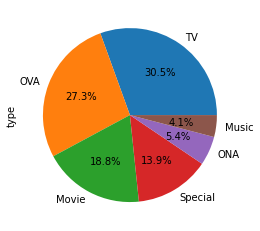

In [15]:
df_anime.type.value_counts().plot(kind='pie', autopct='%1.1f%%')

melihat persebaran rating seluruh anime

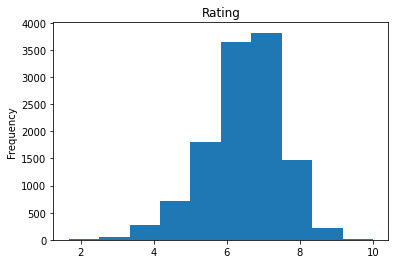

In [16]:
df_anime.rating.plot(kind='hist')
plt.title('Rating')
plt.show()

membuat visualisasi persebaran genre seluruh anime

Text(0, 0.5, 'Counts')

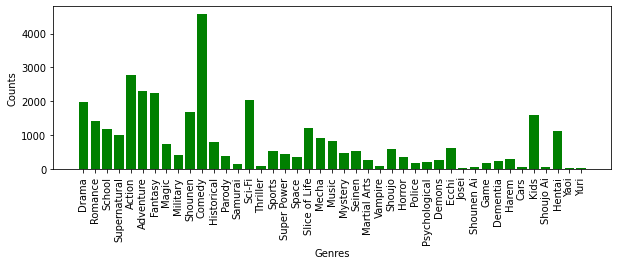

In [17]:
counts = dict()
for i in df_anime.index:
   for g in df_anime.loc[i,'genre'].split(', '):
      if g not in counts:
         counts[g] = 1
      else:
         counts[g] = counts[g] + 1
# create a bar chart
plt.figure(figsize=(10, 3))
plt.bar(list(counts.keys()), counts.values(), color='g')
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Counts')

In [18]:
counts

{'Drama': 1977,
 'Romance': 1437,
 'School': 1176,
 'Supernatural': 1001,
 'Action': 2768,
 'Adventure': 2316,
 'Fantasy': 2242,
 'Magic': 747,
 'Military': 416,
 'Shounen': 1684,
 'Comedy': 4575,
 'Historical': 798,
 'Parody': 403,
 'Samurai': 146,
 'Sci-Fi': 2036,
 'Thriller': 86,
 'Sports': 533,
 'Super Power': 451,
 'Space': 377,
 'Slice of Life': 1204,
 'Mecha': 929,
 'Music': 842,
 'Mystery': 485,
 'Seinen': 532,
 'Martial Arts': 264,
 'Vampire': 100,
 'Shoujo': 594,
 'Horror': 362,
 'Police': 195,
 'Psychological': 226,
 'Demons': 287,
 'Ecchi': 628,
 'Josei': 52,
 'Shounen Ai': 62,
 'Game': 177,
 'Dementia': 238,
 'Harem': 313,
 'Cars': 72,
 'Kids': 1598,
 'Shoujo Ai': 54,
 'Hentai': 1133,
 'Yaoi': 38,
 'Yuri': 41}

In [19]:
df_anime.describe()

,anime_id,rating,members
count,12017.000000,12017.000000,1.201700e+04
mean,13638.001165,6.478264,1.834888e+04
std,11231.076675,1.023857,5.537250e+04
min,1.000000,1.670000,1.200000e+01
25%,3391.000000,5.890000,2.250000e+02
50%,9959.000000,6.570000,1.552000e+03
75%,23729.000000,7.180000,9.588000e+03
max,34519.000000,10.000000,1.013917e+06


In [20]:
len(df_anime)

12017

Menghapus anime yang tidak bertipe TV (Serial)

In [21]:
df_anime = df_anime[df_anime['type'] == 'TV']
df_anime.reset_index(drop=True, inplace = True)
df_anime

,anime_id,name,genre,type,episodes,rating,members
0,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
1,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
2,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
3,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
4,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
...,...,...,...,...,...,...,...
3663,31698,Zhan Long Si Qu,"Cars, Kids",TV,64,4.80,67
3664,31427,Zinba,"Action, Adventure, Comedy, Demons, Magic, Supe...",TV,52,7.17,172
3665,13167,Zoobles!,Kids,TV,26,5.57,109
3666,7808,Zukkoke Knight: Don De La Mancha,"Adventure, Comedy, Historical, Romance",TV,23,6.47,172


membuat visualisasi persebaran genre anime bertipe TV/Serial

Text(0, 0.5, 'Counts')

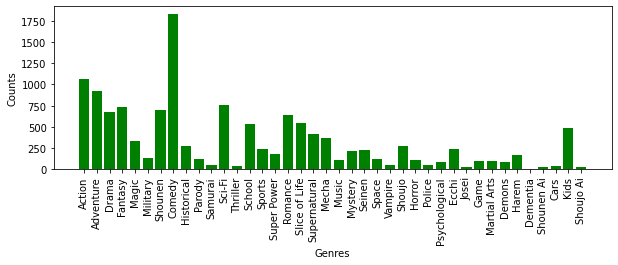

In [22]:
counts = dict()
for i in df_anime.index:
   for g in df_anime.loc[i,'genre'].split(', '):
      if g not in counts:
         counts[g] = 1
      else:
         counts[g] = counts[g] + 1
# create a bar chart
plt.figure(figsize=(10, 3))
plt.bar(list(counts.keys()), counts.values(), color='g')
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Counts')

In [23]:
counts

{'Action': 1064,
 'Adventure': 917,
 'Drama': 679,
 'Fantasy': 732,
 'Magic': 337,
 'Military': 129,
 'Shounen': 699,
 'Comedy': 1828,
 'Historical': 272,
 'Parody': 122,
 'Samurai': 50,
 'Sci-Fi': 757,
 'Thriller': 34,
 'School': 539,
 'Sports': 237,
 'Super Power': 181,
 'Romance': 637,
 'Slice of Life': 549,
 'Supernatural': 411,
 'Mecha': 373,
 'Music': 111,
 'Mystery': 218,
 'Seinen': 222,
 'Space': 122,
 'Vampire': 45,
 'Shoujo': 279,
 'Horror': 110,
 'Police': 49,
 'Psychological': 88,
 'Ecchi': 238,
 'Josei': 30,
 'Game': 103,
 'Martial Arts': 95,
 'Demons': 85,
 'Harem': 172,
 'Dementia': 7,
 'Shounen Ai': 23,
 'Cars': 36,
 'Kids': 482,
 'Shoujo Ai': 30}

Load data rating

In [24]:
df_rating = pd.read_csv('/content/rating.csv')
df_rating

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [25]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


mengecek missing values

In [26]:
df_rating.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [27]:
df_rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


menghapus data anime yang belum pernah dirating dan hanya ditonton user (nilai rating -1)

In [28]:
df_rating = df_rating[df_rating['rating'] >= 0]
df_rating = df_rating[df_rating['anime_id'].isin(df_anime['anime_id'].tolist())]
df_rating.reset_index(drop=True, inplace = True)
df_rating

,user_id,anime_id,rating
0,1,8074,10
1,1,11617,10
2,1,11757,10
3,1,15451,10
4,2,11771,10
...,...,...,...
4364289,73515,14345,7
4364290,73515,16512,7
4364291,73515,22145,10
4364292,73516,790,9


In [29]:
df_rating.describe()

,user_id,anime_id,rating
count,4.364294e+06,4.364294e+06,4.364294e+06
mean,3.662262e+04,9.655958e+03,7.899160e+00
std,2.105185e+04,9.224066e+03,1.524181e+00
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.879900e+04,1.535000e+03,7.000000e+00
50%,3.637600e+04,6.880000e+03,8.000000e+00
75%,5.486800e+04,1.558300e+04,9.000000e+00
max,7.351600e+04,3.342100e+04,1.000000e+01


In [30]:
print('Jumlah user_id: ', len(df_rating.user_id.unique()))
print('Jumlah anime_id: ', len(df_rating.anime_id.unique()))
print('Jumlah data rating: ', len(df_rating))

Jumlah user_id:  68929
Jumlah anime_id:  3069
Jumlah data rating:  4364294


# Content Based Filtering

Menghapus kolom yang tidak diperlukan untuk content based filtering

In [31]:
df_anime_clean = df_anime.drop(columns=['anime_id','type', 'episodes', 'rating', 'members'], axis=1)
df_anime_clean.reset_index(drop=True, inplace = True)
df_anime_clean

,name,genre
0,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili..."
1,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S..."
2,Steins;Gate,"Sci-Fi, Thriller"
3,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S..."
4,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports"
...,...,...
3663,Zhan Long Si Qu,"Cars, Kids"
3664,Zinba,"Action, Adventure, Comedy, Demons, Magic, Supe..."
3665,Zoobles!,Kids
3666,Zukkoke Knight: Don De La Mancha,"Adventure, Comedy, Historical, Romance"


melakukan fitting TF-IDF untuk kolom genre

In [32]:
# create an object for TfidfVectorizer
tfidf_vector = TfidfVectorizer(tokenizer=comma_tokenizer)
# apply the object to the genres column
tfidf_matrix = tfidf_vector.fit_transform(df_anime_clean['genre'])

In [33]:
tfidf_matrix.shape

(3668, 40)

In [34]:
print(list(enumerate(tfidf_vector.get_feature_names())))

[(0, 'action'), (1, 'adventure'), (2, 'cars'), (3, 'comedy'), (4, 'dementia'), (5, 'demons'), (6, 'drama'), (7, 'ecchi'), (8, 'fantasy'), (9, 'game'), (10, 'harem'), (11, 'historical'), (12, 'horror'), (13, 'josei'), (14, 'kids'), (15, 'magic'), (16, 'martial arts'), (17, 'mecha'), (18, 'military'), (19, 'music'), (20, 'mystery'), (21, 'parody'), (22, 'police'), (23, 'psychological'), (24, 'romance'), (25, 'samurai'), (26, 'school'), (27, 'sci-fi'), (28, 'seinen'), (29, 'shoujo'), (30, 'shoujo ai'), (31, 'shounen'), (32, 'shounen ai'), (33, 'slice of life'), (34, 'space'), (35, 'sports'), (36, 'super power'), (37, 'supernatural'), (38, 'thriller'), (39, 'vampire')]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


membuat matrix cosine similarity

In [35]:
# create the cosine similarity matrix
sim_matrix = cosine_similarity(tfidf_matrix) 
print(sim_matrix)

[[1.         0.16939106 0.         ... 0.         0.13395422 0.        ]
 [0.16939106 1.         0.11828487 ... 0.         0.32471879 0.18767359]
 [0.         0.11828487 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.13395422 0.32471879 0.         ... 0.         1.         0.31456961]
 [0.         0.18767359 0.         ... 0.         0.31456961 1.        ]]


In [36]:
# a function to convert index to name
def get_name_from_index(index):
   return df_anime_clean[df_anime_clean.index == index]['name'].values[0]
# a function to convert title to index
def get_index_from_name(name):
   return df_anime_clean[df_anime_clean.name == name].index.values[0]
def get_genre_from_index(index):
  return df_anime_clean[df_anime_clean.index == index]['genre'].values[0]
# a function to return the most similar title to the words a user type
def find_closest_title(name):
   leven_scores = list(enumerate(df_anime_clean['name'].apply(matching_score, b=name)))
   sorted_leven_scores = sorted(leven_scores, key=lambda x: x[1], reverse=True)
   closest_name = get_name_from_index(sorted_leven_scores[0][0])
   distance_score = sorted_leven_scores[0][1]
   return closest_name, distance_score

In [37]:
def contents_based_recommender(anime_user_likes, how_many):
   closest_title, distance_score = find_closest_title(anime_user_likes)
   # When a user does not make misspellings
   if distance_score == 100:
      movie_index = get_index_from_name(closest_title)
      movie_list = list(enumerate(sim_matrix[int(movie_index)]))
      # remove the typed movie itself
      similar_anime = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True))) 
      
      print('Here\'s the list of anime similar to '+'\033[1m'+str(closest_title)+'\033[0m : '+get_genre_from_index(movie_index)+'.\n')
      for i,s in similar_anime[:how_many]:
         print(get_name_from_index(i), ": ",get_genre_from_index(i))
   # When a user makes misspellings    
   else:
      print('Did you mean '+'\033[1m'+str(closest_title)+'\033[0m'+'?','\n')
      movie_index = get_index_from_name(closest_title)
      movie_list = list(enumerate(sim_matrix[int(movie_index)]))
      similar_anime = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True)))
      print('Here\'s the list of anime similar to '+'\033[1m'+str(closest_title)+'\033[0m : '+get_genre_from_index(movie_index)+'.\n')
      for i,s in similar_anime[:how_many]:
         print(get_name_from_index(i), ": ",get_genre_from_index(i))

mencari rekomendasi anime sejenis Naruto

In [38]:
contents_based_recommender('Naruto', 10)

Here's the list of anime similar to Naruto : Action, Comedy, Martial Arts, Shounen, Super Power.

Naruto: Shippuuden :  Action, Comedy, Martial Arts, Shounen, Super Power
Rekka no Honoo :  Action, Adventure, Martial Arts, Shounen, Super Power
Kurokami The Animation :  Action, Martial Arts, Super Power
Project ARMS :  Action, Martial Arts, Super Power
Wolverine :  Action, Martial Arts, Super Power
Dragon Ball Z :  Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power
Dragon Ball Kai (2014) :  Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power
Dragon Ball Kai :  Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power
Dragon Ball Super :  Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power
Dragon Ball :  Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power


Output Jika terjadi typo

In [39]:
contents_based_recommender('Baruto', 10)

Did you mean Naruto? 

Here's the list of anime similar to Naruto : Action, Comedy, Martial Arts, Shounen, Super Power.

Naruto: Shippuuden :  Action, Comedy, Martial Arts, Shounen, Super Power
Rekka no Honoo :  Action, Adventure, Martial Arts, Shounen, Super Power
Kurokami The Animation :  Action, Martial Arts, Super Power
Project ARMS :  Action, Martial Arts, Super Power
Wolverine :  Action, Martial Arts, Super Power
Dragon Ball Z :  Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power
Dragon Ball Kai (2014) :  Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power
Dragon Ball Kai :  Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power
Dragon Ball Super :  Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power
Dragon Ball :  Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power


# Collaborative Filtering


In [40]:
df = df_rating
df

,user_id,anime_id,rating
0,1,8074,10
1,1,11617,10
2,1,11757,10
3,1,15451,10
4,2,11771,10
...,...,...,...
4364289,73515,14345,7
4364290,73515,16512,7
4364291,73515,22145,10
4364292,73516,790,9


encoding user_id

In [41]:
# Mengubah user_id menjadi list tanpa nilai yang sama
user_ids = df['user_id'].unique().tolist()
print('list user_id: ', user_ids)
 
# Melakukan encoding user_id
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded user_id : ', user_to_user_encoded)
 
# Melakukan proses encoding angka ke ke user_id
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke user_id: ', user_encoded_to_user)

list user_id:  [1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231

encoding anime_id

In [42]:
# Mengubah anime_id menjadi list tanpa nilai yang sama
anime_ids = df['anime_id'].unique().tolist()
 
# Melakukan proses encoding anime_id
anime_to_anime_encoded = {x: i for i, x in enumerate(anime_ids)}
 
# Melakukan proses encoding angka ke anime_id
anime_encoded_to_anime = {i: x for i, x in enumerate(anime_ids)}

In [43]:
# Mapping user_id ke dataframe user
df['user'] = df['user_id'].map(user_to_user_encoded)
 
# Mapping anime_id ke dataframe
df['anime'] = df['anime_id'].map(anime_to_anime_encoded)

In [44]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)
 
# Mendapatkan jumlah anime
num_anime = len(anime_encoded_to_anime)
print(num_anime)
 
# Mengubah rating menjadi nilai float
df['rating'] = df['rating'].values.astype(np.float32)
 
# Nilai minimum rating
min_rating = min(df['rating'])
 
# Nilai maksimal rating
max_rating = max(df['rating'])
 
print('Number of User: {}, Number of Anime: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_anime, min_rating, max_rating
))

68929
3069
Number of User: 68929, Number of Anime: 3069, Min Rating: 1.0, Max Rating: 10.0


mengacak dataset

In [45]:
df = df.sample(frac=1, random_state=42)
df

,user_id,anime_id,rating,user,anime
232471,4111,30015,7.0,3831,629
4146570,69491,14967,7.0,65174,250
167504,3008,20787,6.0,2792,305
3867290,64698,28497,6.0,60687,63
2620470,44411,67,5.0,41567,79
...,...,...,...,...,...
1136074,19508,19163,7.0,18265,289
1570006,26201,6045,10.0,24562,876
2234489,37473,25013,8.0,35108,824
4304572,72458,9919,7.0,67939,25


melakukan train-test-split

In [46]:
# Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value
x = df[['user', 'anime']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 8900% data train dan 10% data validasi
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

[[ 3831   629]
 [65174   250]
 [ 2792   305]
 ...
 [35108   824]
 [67939    25]
 [26237   710]] [0.66666667 0.66666667 0.55555556 ... 0.77777778 0.66666667 0.88888889]


In [47]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.anime_embedding = layers.Embedding( # layer embeddings anime
        num_anime,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.anime_bias = layers.Embedding(num_anime, 1) # layer embedding anime bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    anime_vector = self.anime_embedding(inputs[:, 1]) # memanggil layer embedding 3
    anime_bias = self.anime_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_anime = tf.tensordot(user_vector, anime_vector, 2) 
 
    x = dot_user_anime + user_bias + anime_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

In [48]:
model = RecommenderNet(num_users, num_anime, 64) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.RMSprop(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [49]:
# Memulai training
 
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 256,
    epochs = 15,
    validation_data = (x_val, y_val)
)

Epoch 1/15
15344/15344 [==============================] - 523s 34ms/step - loss: 0.5319 - root_mean_squared_error: 0.1577 - val_loss: 0.5229 - val_root_mean_squared_error: 0.1455
Epoch 2/15
15344/15344 [==============================] - 514s 33ms/step - loss: 0.5198 - root_mean_squared_error: 0.1419 - val_loss: 0.5179 - val_root_mean_squared_error: 0.1394
Epoch 3/15
15344/15344 [==============================] - 541s 35ms/step - loss: 0.5160 - root_mean_squared_error: 0.1374 - val_loss: 0.5154 - val_root_mean_squared_error: 0.1365
Epoch 4/15
15344/15344 [==============================] - 554s 36ms/step - loss: 0.5139 - root_mean_squared_error: 0.1349 - val_loss: 0.5139 - val_root_mean_squared_error: 0.1347
Epoch 5/15
15344/15344 [==============================] - 596s 39ms/step - loss: 0.5127 - root_mean_squared_error: 0.1334 - val_loss: 0.5131 - val_root_mean_squared_error: 0.1337
Epoch 6/15
15344/15344 [==============================] - 568s 37ms/step - loss: 0.5120 - root_mean_squar

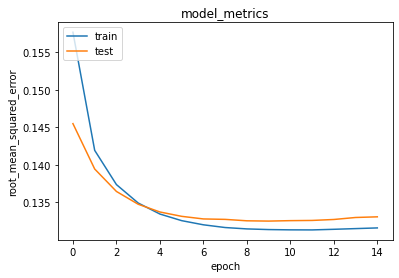

In [50]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
# Mengambil sample user
user_id = df.user_id.sample(1).iloc[0]
anime_watched_by_user = df[df.user_id == user_id]
 
# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html 
anime_not_watched_by_user = df_anime[~df_anime['anime_id'].isin(anime_watched_by_user.anime_id.values)]['anime_id'] 
anime_not_watched_by_user = list(
    set(anime_not_watched_by_user)
    .intersection(set(anime_to_anime_encoded.keys()))
)
 
anime_not_watched_by_user = [[anime_to_anime_encoded.get(x)] for x in anime_not_watched_by_user]
user_encoder = user_to_user_encoded.get(user_id)
user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched_by_user), anime_not_watched_by_user)
)

In [52]:
ratings = model.predict(user_anime_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_anime_ids = [
    anime_encoded_to_anime.get(anime_not_watched_by_user[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Anime with high ratings from user')
print('----' * 8)
 
top_anime_user = (
    anime_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(10)
    .anime_id.values
)
 
anime_df_rows = df_anime[df_anime['anime_id'].isin(top_anime_user)]
for row in anime_df_rows.itertuples():
    print(row.name, ':', row.genre)
 
print('----' * 8)
print('Top 10 anime recommendation')
print('----' * 8)
 
recommended_anime = df_anime[df_anime['anime_id'].isin(recommended_anime_ids)]
for row in recommended_anime.itertuples():
    print(row.name, ':', row.genre)

96/96 [==============================] - 0s 912us/step
Showing recommendations for users: 34899
Anime with high ratings from user
--------------------------------
Fullmetal Alchemist: Brotherhood : Action, Adventure, Drama, Fantasy, Magic, Military, Shounen
Steins;Gate : Sci-Fi, Thriller
Code Geass: Hangyaku no Lelouch R2 : Action, Drama, Mecha, Military, Sci-Fi, Super Power
Code Geass: Hangyaku no Lelouch : Action, Mecha, Military, School, Sci-Fi, Super Power
Mushishi : Adventure, Fantasy, Historical, Mystery, Seinen, Slice of Life, Supernatural
NHK ni Youkoso! : Comedy, Drama, Psychological, Romance
Fullmetal Alchemist : Action, Adventure, Comedy, Drama, Fantasy, Magic, Military, Shounen
Dragon Ball Z : Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power
Dragon Ball : Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power
Higashi no Eden : Action, Comedy, Drama, Mystery, Romance, Sci-Fi, Thriller
--------------------------------
Top 10 anime recommendation
